<img src="res/itm_logo.jpg" width="300px">

## Inteligencia Artificial - IAI84
### Instituto Tecnológico Metropolitano
#### Pedro Atencio Ortiz - 2018

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import figaspect

<hr>
<h1>1. Funciones de activación</h1>

In [2]:
def f_act(z, function='sigmoid', args={'k':0.1}):
    '''
    Activation functions for neural network layers.
    
    Parameters:
        z: linear activation input.
        function: 'sigmoid', 'tanh', 'relu', 'leaky_relu', 'softmax'.
        args: dictionary of special arguments.
    '''
    if(function == 'sigmoid'):
        a = 1. / (1 + np.exp(-z))
    elif(function == 'tanh'):
        a = (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
    elif(function == 'relu'):
        a = np.maximum(z, 0)
    elif(function == 'leaky_relu'):
        k = args['k']
        a = np.maximum(z, k*z)
    elif(function == 'softmax'):
        t = np.exp(z)
        a = t / np.sum(np.exp(z), axis=0)
    else:
        print('function ' + function + ' is not recognized.')
        return False

    return a

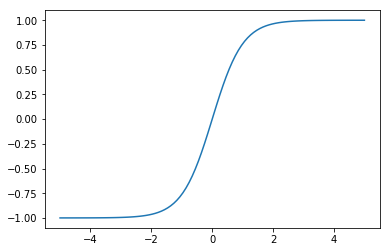

In [3]:
z = np.linspace(-5,5,100)
args = {'k':0.2}
a = f_act(z, 'tanh', args)

plt.plot(z,a)
plt.show()

<hr>
<h1>2. Derivada de las funciones de activación</h1>

In [4]:
def df_act(z, function='sigmoid', args={'k':0.1}):
    '''
    Derivative of activation functions for neural network layers. 
    
    Parameters:
        z: linear activation input.
        function: 'sigmoid', 'tanh', 'relu', 'leaky_relu', 'softmax'.
        args: dictionary of special arguments.
    '''
    if(function == 'sigmoid'):
        a = 1. / (1 + np.exp(-z))
        d = a * (1 - a)
    elif(function == 'tanh'):
        a = (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
        d = 1. - a**2
    elif(function == 'relu'):
        d = np.copy(z)
        d[d >= 0] = 1
        d[d < 0] = 0
    elif(function == 'leaky_relu'):
        k = args['k']
        d = np.copy(z)
        d[d >= 0] = 1
        d[d < 0] = k
    elif(function == 'softmax'):
        t = np.exp(z)
        a = t / np.sum(np.exp(z), axis=0)
        d = a * (1 - a)
    else:
        print('function ' + function + ' is not recognized.')
        return False

    return d

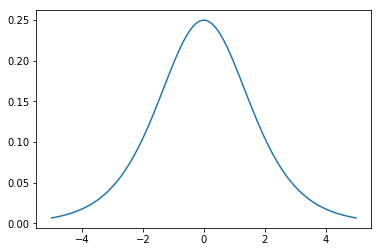

In [5]:
z = np.linspace(-5,5,100)
args = {'k':0.2}
a = df_act(z, 'sigmoid', args)

plt.plot(z,a)
plt.show()

<hr>


# 3. Normalizacion de la entrada.

Como vimos en la sesion anterior, es deseable que la entrada del sistema se encuentre normalizada, con el objetivo de facilitar la convergencia del descenso del gradiente.

Para ello utilizamos las siguientes ecuaciones:

### <center>$x = x - \mu$</center>
### <center>$x = \frac{x}{\sigma}$</center>

Donde $\mu$ y $\sigma$ son la media y la desviación estándar de la entrada $x$ respectivamente.

In [6]:
def normalize_input(X):
    x = np.copy(X)
    
    v_x = np.std(x, axis=0)
    m_x = np.mean(x, axis=0)
    
    x -= m_x
    x /= v_x
    
    return x

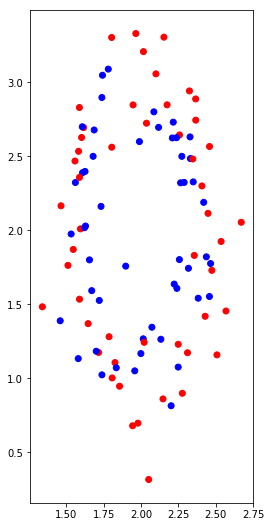

In [7]:
from utils import generate_data

X, Y = generate_data('circles')
nx,m = X.T.shape

X = X * np.array([0.5, 1.]) + np.array([2., 2.])

color= ['blue' if y == 1 else 'red' for y in np.squeeze(Y)]


data_range = (np.max(X[:,1]) - np.min(X[:,1]))  / (np.max(X[:,0]) - np.min(X[:,0]))
w, h = figaspect(data_range)
plt.figure(figsize=(w,h))
plt.scatter(X[:,0], X[:,1], color=color)

plt.show()

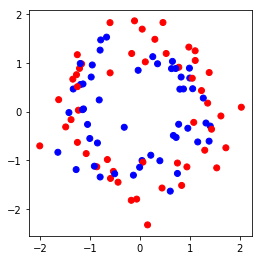

In [8]:
Xn = normalize_input(X)

data_range = (np.max(Xn[:,1]) - np.min(Xn[:,1]))  / (np.max(Xn[:,0]) - np.min(Xn[:,0])) 
w, h = figaspect(data_range)
plt.figure(figsize=(w,h))
plt.scatter(Xn[:,0], Xn[:,1], color=color)

plt.show()


<hr>

# 4. Inicializacion de parametros de la red.

Utilizar unos valores de inicializacion de los pesos de la red $W^{[l]}$, muy bajos o muy altos, puede conducir al problema de la desvanecimiento o explosion de los gradientes, respectivamente. Es por ello que se hace necesario inicializar los pesos con un valor adecuado.

Segun analizamos en la clase anterior, existen aproximaciones formales para ello. Algunas formas son:

### <center>$W^{[l]} = np.random.randn(W^{[l]}.shape) * \sqrt{\frac{1}{n^{[l-1]}}}$</center>

### <center>$W^{[l]} = np.random.randn(W^{[l]}.shape) * \sqrt{\frac{2}{n^{[l-1]}}}$</center>

Xavier's Initialization:
### <center>$W^{[l]} = np.random.randn(W^{[l]}.shape) * \sqrt{ \frac{2}{n^{[l-1]} +n^{[l]} } }$</center>

In [26]:
#Xavier's Initialization
def initialize_parameters(neurons_hidden_layer):

    len_X = 2
    
    W1 = np.random.randn(neurons_hidden_layer, len_X) * np.sqrt(2./float(len_X + neurons_hidden_layer))
    b1 = np.zeros([neurons_hidden_layer,1])

    W2 = np.random.randn(1,neurons_hidden_layer) * np.sqrt(2./float(neurons_hidden_layer+1))
    b2 = np.zeros([1,1])
    
    parameters = {"W1":W1, "b1":b1, "W2":W2, "b2":b2}
    
    return parameters

<hr>

# 5. Regularization

Esta técnica permite reducir el problema de la alta varianza (High Variance), entendido como una alta diferencia entre el error medido sobre el dataset de entrenamiento (TRAIN SET) y de prueba (DEV SET). Por otra parte, permite reducir el sobreentrenamiento de la red neuronal, es decir, permite entrenas redes que encuentren soluciones mas generales.

En terminos de implementacion, la regularizacion L2 o de Frobenius implica agregar un nuevo termino al gradiente de los pesos:

### <center>$dW^{[l]} = dW^{[l]} + \frac{\lambda}{m}W^{[l]}$</center>

Donde $\lambda$ se conoce como el termino de regularizacion y $m$ se refiere al numero de ejemplos del dataset.

In [17]:
def linear_activation(W, b, X):
    z = np.dot(W, X) + b
    
    return z

def loss(y, a):
    return -(y * np.log(a) + (1.-y) * np.log(1-a))

def cost(logloss):
    return np.mean(logloss)

def predict_multilayer(parameters,X):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
        
    Z1 = linear_activation(W1,b1,X)
    A1 = f_act(Z1, 'relu')
    
    Z2 = linear_activation(W2,b2,A1)
    A2 = f_act(Z2, 'sigmoid')

    return np.round(A2)
    
    
def visualize_lr(parameters, X, Y):
    X = X.T
    
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = predict_multilayer(parameters, np.c_[xx.ravel(), yy.ravel()].T)
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.figure(figsize=(7,5))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    
    color= ['blue' if y == 1 else 'red' for y in np.squeeze(Y)]
    plt.scatter(X[:,0], X[:,1], color=color)
    
    plt.show()

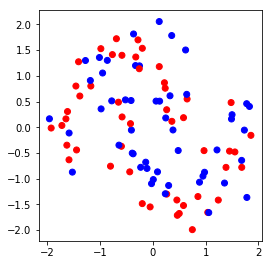

In [51]:
X, Y = generate_data('moons')

Xn = normalize_input(X)

data_range = (np.max(Xn[:,1]) - np.min(Xn[:,1]))  / (np.max(Xn[:,0]) - np.min(Xn[:,0])) 
w, h = figaspect(data_range)
plt.figure(figsize=(w,h))
plt.scatter(Xn[:,0], Xn[:,1], color=color)

plt.show()

X = Xn.T

In [60]:
'''
Metaparameters initialization
'''
num_epochs = 20000
learning_rate = 0.01
reg_param = 0.05

'''
Parameters initialization
'''
parameters = initialize_parameters(5)
W1 = parameters["W1"]
b1 = parameters["b1"]
W2 = parameters["W2"]
b2 = parameters["b2"]

print ("parametros iniciales: ", parameters)

'''
Gradient descent
'''
for i in range(num_epochs):
    '''
    Forward Propagation
    '''
    Z1 = linear_activation(W1, b1, X)
    A1 = f_act(Z1, function='relu')
    
    Z2 = linear_activation(W2, b2, A1)
    A2 = f_act(Z2, function='sigmoid')
        
    '''
    Backward Propagation
    '''
    dZ2 = A2 - Y
    dW2 = np.dot(dZ2, A1.T) / m
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m
    
    dZ1 = np.multiply(np.dot(W2.T, dZ2), df_act(Z1, 'relu'))
    dW1 = np.dot(dZ1, X.T) / m
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m
    
    '''
    Regularization
    '''
    dW1 = dW1 + reg_param * W1
    dW2 = dW2 + reg_param * W2
    
    '''
    Parameters Update
    '''
    W1 -= learning_rate * dW1
    W2 -= learning_rate * dW2
    b1 -= learning_rate * db1
    b2 -= learning_rate * db2
    
    '''
    Cost estimation
    '''
    J = cost(loss(Y,A2))
    
    
    if(i%1000 == 0):
        print("costo -- iteracion ", i, ": ", J)
        
print("parametros actualizados: ", parameters)

'''
Testing
'''
print("Predicciones del clasificador: ", predict_multilayer(parameters,X))

('parametros iniciales: ', {'b2': array([[0.]]), 'b1': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]]), 'W1': array([[ 0.30991549, -0.72360064],
       [-0.38460318, -0.06340298],
       [-0.4319562 , -0.38427406],
       [-0.30657212, -0.20508408],
       [ 0.15588495,  0.0389437 ]]), 'W2': array([[-0.0107123 ,  0.05775655,  0.24715265, -0.6003218 ,  0.16814078]])})
('costo -- iteracion ', 0, ': ', 0.6895219684090681)
('costo -- iteracion ', 1000, ': ', 0.10622166932969865)
('costo -- iteracion ', 2000, ': ', 0.06651395400962891)
('costo -- iteracion ', 3000, ': ', 0.05948742399377115)
('costo -- iteracion ', 4000, ': ', 0.05500699886627965)
('costo -- iteracion ', 5000, ': ', 0.051380464337137395)
('costo -- iteracion ', 6000, ': ', 0.049172906790223854)
('costo -- iteracion ', 7000, ': ', 0.047925047429293384)
('costo -- iteracion ', 8000, ': ', 0.047179259408223165)
('costo -- iteracion ', 9000, ': ', 0.04673210000466292)
('costo -- iteracion ', 10000, ': ', 0.046

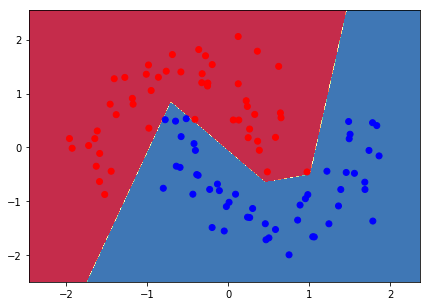

In [61]:
visualize_lr(parameters, X, Y)